# Kalman Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt

With the histogram filter we described the distribution using histograms. For the Kalman filter we use Gaussians.

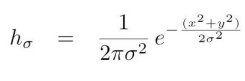

This is implemented in the code below:

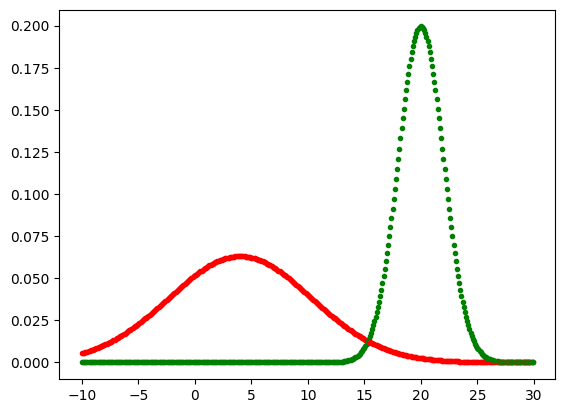

In [2]:
def f(u, sigma2, x):
    return 1/np.sqrt(2*np.pi*sigma2) * np.exp(-0.5* ((x-u)**2/sigma2))

u = 4        # Mean for the first Gaussian
v = 20       # Mean for the second Gaussian
sigma2 = 40  # Variance for the first Gaussian
r2 = 4       # Variance for the second Gaussian

for x in np.arange(-10, 30, 0.1):
    plt.plot(x, f(u, sigma2, x),'.r')
    plt.plot(x, f(v, r2, x),'.g')

# Exercise 2a
We have here plotted two distributions. The Kalman filter makes its measurement update by combining the information from these two gaussians. 

Plot the final Gaussian after the measurement update based on the two Gaussians plotted above. Use the following formulas to do so:

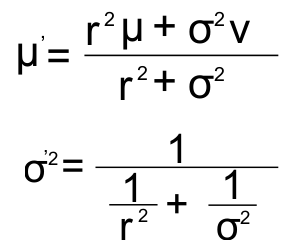

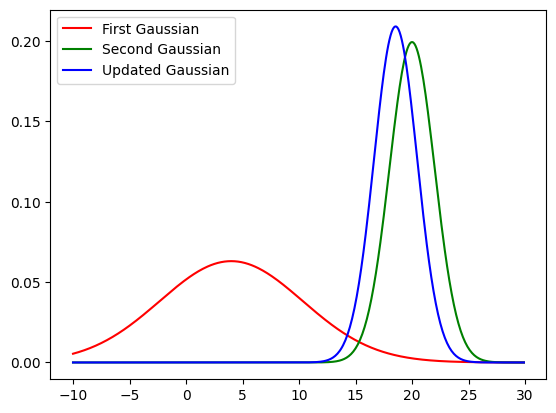

In [3]:
### Exercise 2a
### Compute and plot the Gaussian after measurement update
new_mean = (r2 * u + sigma2 * v) / (r2 + sigma2)
new_variance = 1 / ((1/r2) + (1/sigma2))

x_vals = np.arange(-10, 30, 0.1)

# Plot the two original Gaussians
plt.plot(x_vals, f(u, sigma2, x_vals), 'r-', label='First Gaussian')
plt.plot(x_vals, f(v, r2, x_vals), 'g-', label='Second Gaussian')
plt.plot(x_vals, f(new_mean, new_variance, x_vals), 'b-', label='Updated Gaussian')
plt.legend()
plt.show()


Notice that the resulting Gaussian has a higher peak than both of the others. This means that combining the two Gaussians we get a result that has less uncertainty than either of the original Gaussians.



 
 
 






Next we have the prediction or motion update. This one is simply made by adding the motion to the Gaussian mean and the motion variance to the Gaussian variance:


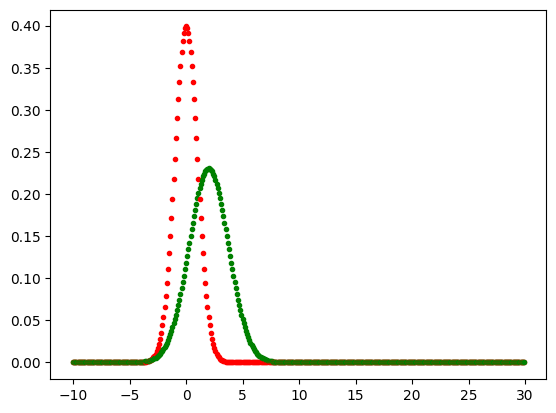

In [4]:
def predict(u1, s2_1, u2, s2_2):
    u = u1 + u2
    s2 = s2_1 + s2_2
    return [u, s2]

u = 0
s2 = 1

motion = 2
motion_sigma2 = 2

[u_pred, s2_pred] = predict(u, s2, motion, motion_sigma2)

for x in np.arange(-10, 30, 0.1):
    plt.plot(x, f(u, s2, x),'.r')
    plt.plot(x, f(u_pred, s2_pred, x),'.g')

# Exercise 2b
Combine the update function you made in the previous exercise with the predict function given above and plot all the Gaussians calculated using the measurements and motions given in the code below:

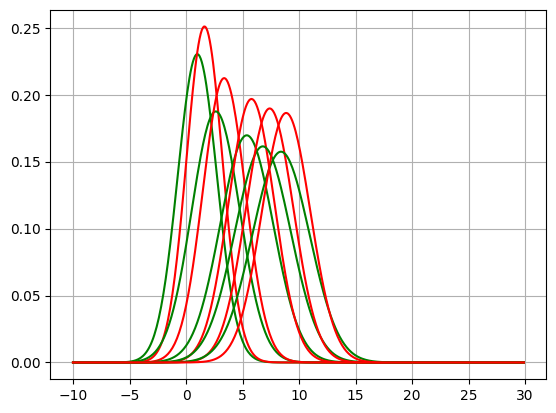

In [5]:
### Exercise 2b
measurements = [5, 6, 7, 9, 10]
measure_sigma = 4
motion = [1, 1, 2, 1, 1]
motion_sigma = 2

# Compute Gaussians and plot after each update/prediction
def update(u, sigma2, z, measure_sigma):
    new_mean = (measure_sigma**2 * u + sigma2 * z) / (measure_sigma**2 + sigma2)
    new_variance = 1 / (1/measure_sigma**2 + 1/sigma2)
    return new_mean, new_variance

# Initial state
u = 0
sigma2 = 1

# Create x values for plotting
x_vals = np.arange(-10, 30, 0.1)

# Iterate through measurements and motions
for i in range(len(measurements)):
    # Predict step (motion)
    [u, sigma2] = predict(u, sigma2, motion[i], motion_sigma)
    plt.plot(x_vals, f(u, sigma2, x_vals), 'g-')

    # Update step (measurement)
    [u, sigma2] = update(u, sigma2, measurements[i], measure_sigma)
    plt.plot(x_vals, f(u, sigma2, x_vals), 'r-')

# Show the plot with legends
plt.grid(True)
plt.show()

# Exercise 2c

It's now time to look at the more general equations of the Kalman filter. We would like to apply a Kalman filter for a robot moving in 1D. We would like to track and predict its position and its velocity. 

A quick summary of the variables:

**x** : The state matrix. Holds the state of the robot, which is its position and velocity.

**P** : The uncertainty of the state.

**u** : The external motion. In this case there will not be an external motion affecting the robot.

**F** : The transition matrix (or next state function). Used to predict the next state of the robot.

**H** : The observation matrix (or measurement function). Used to update the robot state.

**R** : The measurement uncertainty. 

**I** : Identity matrix.

You will now have to implement your own update and predict function using the formulas given here. All the matrices are given in the code below. 

When you multiply matrices together you can use [np.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html). To get the inverse of a matrix, you can use [np.linalg.pinv](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html). To get the transpose you can use [np.transpose](https://docs.scipy.org/doc/numpy/reference/generated/numpy.transpose.html).

The two equations written in black are the equations used for prediction and the rest are the equations used for updating.

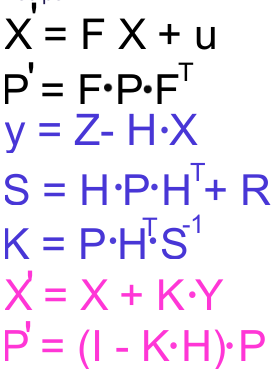

In [6]:
# The initial state. The robot starts in position 0 with the velocity 0.
x = np.array([[0],
              [0]])

# The initial uncertainty. We start with some very large values.
P = np.array([[1000, 0],
              [0, 1000]])

# The external motion. Set to 0 here.
u = np.array([[0],
              [0]])

# The transition matrix. 
F = np.array([[1, 1],
              [0, 1]])

# The observation matrix. We only get the position as measurement.
H = np.array([[1, 0]])

# The measurement uncertainty
R = 1

# The identity matrix. Simply a matrix with 1 in the diagonal and 0 elsewhere.
I = np.array([[1, 0],
              [0, 1]])

# The measured position. The robot move 1 every time, but due to sensor uncertainties, we measure a bit off.
measurements = [1, 2.1, 2.9, 4.1, 5.0, 5.9, 7.1, 8.1]

def update(x, P, Z, H, R):
    y = Z - np.dot(H, x) 
    S = np.dot(H, np.dot(P, np.transpose(H))) + R  
    K = np.dot(P, np.dot(np.transpose(H), np.linalg.inv(S)))  
    x = x + np.dot(K, y)
    P = np.dot((I - np.dot(K, H)), P)
    
    return x, P
    
def predict(x, P, F, u):
    x = np.dot(F, x) + u
    P = np.dot(F, np.dot(P, np.transpose(F)))
    
    return x, P
    
### Loop through the measurements ###
for Z in measurements:
    x, P = predict(x, P, F, u)
    x, P = update(x, P, Z, H, R)
    
    # Print the updated state and uncertainty
    print(f"Updated state x: {x.flatten()}")
    print(f"Updated uncertainty P: \n{P}\n")


Updated state x: [0.99950025 0.49975012]
Updated uncertainty P: 
[[9.99500250e-01 4.99750125e-01]
 [4.99750125e-01 5.00249875e+02]]

Updated state x: [2.09880626 1.09751629]
Updated uncertainty P: 
[[0.99801291 0.99503377]
 [0.99503377 1.98708839]]

Updated state x: [2.94959233 0.9496259 ]
Updated uncertainty P: 
[[0.83264071 0.49908584]
 [0.49908584 0.49875345]]

Updated state x: [4.03969731 1.00979829]
Updated uncertainty P: 
[[0.69966054 0.29969051]
 [0.29969051 0.19971048]]

Updated state x: [5.01980813 0.99990609]
Updated uncertainty P: 
[[0.59980023 0.19986016]
 [0.19986016 0.09990012]]

Updated state x: [5.9570225  0.98281301]
Updated uncertainty P: 
[[0.52367812 0.14278238]
 [0.14278238 0.05709963]]

Updated state x: [7.01418269 0.99996635]
Updated uncertainty P: 
[[0.46419267 0.10709825]
 [0.10709825 0.03569262]]

Updated state x: [8.04991432 1.00711812]
Updated uncertainty P: 
[[0.41659726 0.08330458]
 [0.08330458 0.02379748]]



Notice how the uncertainty **P** gets smaller and the predicted states gets more accurate than the actual measurements.

# Exercise 2d
Extent the previous matrices such that the robot can move in 2D. The update and predict functions don't have to be changed, only the matrices. For example the state matrix will now have to hold both the position and velocity in both the x- and y-direction: 


In [7]:
# The initial state. The robot starts in position 0 with the velocity 0.
x = np.array([[0], # Position along the x-axis
              [0], # Velocity along the x-axis
              [0], # Position along the y-axis
              [0]])# Velocity along the y-axis

### Update the rest of the parameters 
# Initial uncertainty
P = np.array([[1000, 0, 0, 0], 
              [0, 1000, 0, 0], 
              [0, 0, 1000, 0], 
              [0, 0, 0, 1000]])

# No external motion
u = np.array([[0], [0], [0], [0]])

# Transition matrix for 2D (x and y)
F = np.array([[1, 1, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 1],
              [0, 0, 0, 1]])

# Observation matrix for 2D (only position is measured)
H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

# Measurement uncertainty (position in x and y)
R = np.array([[1, 0],
              [0, 1]])

# Identity matrix (4x4 for 2D)
I = np.eye(4)

# You can use the following measurements or come up with your own. 
measurements_x = [1, 2.1, 2.9, 4.1, 5.0, 5.9, 7.1]
measurements_y = [1, 1.45, 2.0, 2.55, 3, 3.5, 4.05]

for i in range(len(measurements_x)):
    z = np.array([[measurements_x[i]],
                  [measurements_y[i]]])
    
    # Predict the next state
    x, P = predict(x, P, F, u)
    
    # Update the state with the new measurement
    x, P = update(x, P, Z, H, R)
    
    # Print updated state and uncertainty
    print(f"Updated state after measurement {i+1}:")
    print(f"Position x: {x[0,0]}, Velocity x: {x[1,0]}")
    print(f"Position y: {x[2,0]}, Velocity y: {x[3,0]} \n")
    print(f"Updated uncertainty P: \n{P}\n")

Updated state after measurement 1:
Position x: 8.095952023988005, Velocity x: 4.0479760119940025
Position y: 8.095952023988005, Velocity y: 4.0479760119940025 

Updated uncertainty P: 
[[9.99500250e-01 4.99750125e-01 0.00000000e+00 0.00000000e+00]
 [4.99750125e-01 5.00249875e+02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.99500250e-01 4.99750125e-01]
 [0.00000000e+00 0.00000000e+00 4.99750125e-01 5.00249875e+02]]

Updated state after measurement 2:
Position x: 8.108035642467087, Velocity x: 0.024131058459723853
Position y: 8.108035642467087, Velocity y: 0.024131058459723853 

Updated uncertainty P: 
[[0.99801291 0.99503377 0.         0.        ]
 [0.99503377 1.98708839 0.         0.        ]
 [0.         0.         0.99801291 0.99503377]
 [0.         0.         0.99503377 1.98708839]]

Updated state after measurement 3:
Position x: 8.105383396147017, Velocity x: 0.008077113498901813
Position y: 8.105383396147017, Velocity y: 0.008077113498901813 

Updated uncertain